#                           Telecom Customers Churn

## Install Packages 

 Please install the below packages neccesary to run this file(**Note:** imblearn and sklearn versions should be campatible). 

In [123]:
import sys
#!{sys.executable} -m pip install pandas 
#!{sys.executable} -m pip install sklearn 
#!{sys.executable} -m pip install imblearn 
#!{sys.executable} -m pip install seaborn 

In [124]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency,chi2
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,roc_auc_score
from sklearn.model_selection import GridSearchCV,KFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


np.random.seed(31415)

## Load Telco users dataset 

In [125]:
data = pd.read_csv("C:/PC/Profusion/telecom_users.csv",index_col = 0)

In [126]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

 Here, feature 'TotalCharges' is of a type object, we should convert it into a float

In [127]:
print(data.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Here,It is intresting to notice tenure minimum value is 0 while montlycharges are  not, let's dig little deeper into this 
to understand phenomenon

In [128]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5986.000000,5986.000000,5986.000000
mean,0.161377,32.468760,64.802213
std,0.367909,24.516391,30.114702
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.650000
50%,0.000000,29.000000,70.400000
75%,0.000000,56.000000,89.900000
max,1.000000,72.000000,118.750000


It can seen below, there are 10 records with 'tenure' as 0 and corresponding 'TotalCharges' column values are empty,
Which might mean users have reistered for service but not activated the plan.
Lets replace 'TotalCharges' with 0's and convert the column into float 

In [129]:
data[data['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6754,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No


In [130]:
data.loc[data['tenure'] == 0,'TotalCharges'] = 0
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

## Data Ananlysis 

Now,we dont have any NA values and all fetaures are converted into required type, Lets start with data ananlysis 

In [131]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [132]:
df_churn = data[data["Churn"]=="Yes"] 
df_retained = data[data["Churn"]=="No"]


As can be seen below, churn data is approximatly 25% , so data set  is imbalance. resampling techiniques like oversampling or undersampling can be appropriatly used later before fitting the data  

In [133]:
print(df_churn.shape)
print(df_retained.shape)

(1587, 21)
(4399, 21)


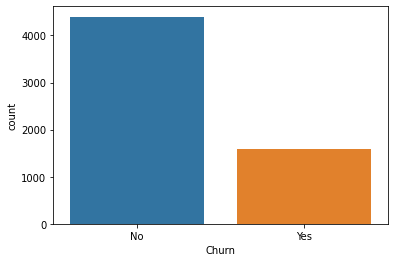

In [134]:
churn_bar = sns.countplot(x='Churn',data=data)
plt.show()

Here, As can been seen, most of the churning happening in the initials months , and as tenure goes on , 
it is more likely to retain the customer , perticular after 70 month tenure , custamer more likely to stay back 

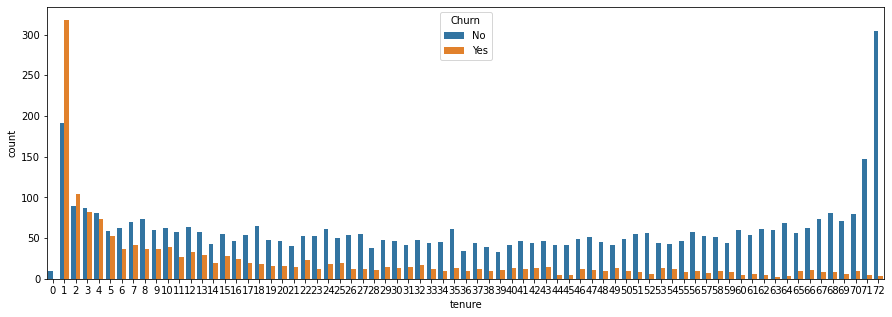

In [135]:
plt.figure(figsize = (15,5))
sns.countplot(x=data.tenure, hue = data.Churn)
plt.show()

It can be obeserved from the below graphs, most of the churned users spend around 60-100 dollers per month,
while it is much smaller for retained custamers , that is 20-60.
From this,we may infer,high monthly spending  is one of the reasons for leaving the network   

<Figure size 432x288 with 0 Axes>

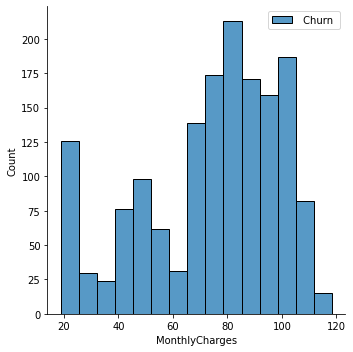

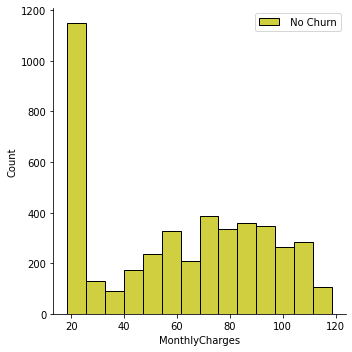

In [136]:
plt.figure("MonthlyCharges")
sns.displot(data=df_churn,x = 'MonthlyCharges',label=" Churn ")
plt.legend()
sns.displot(data=df_retained,x = 'MonthlyCharges',label=" No Churn",color ='y')
plt.legend()
plt.show()


It can be seen in the below plots,number of people have high amount of 'TotalCharges' in churned data set is much
less campared to retained users data set. This reitarates our earlier obervation , that many customers are the leaving 
network in the initial months of service itself.

<Figure size 432x288 with 0 Axes>

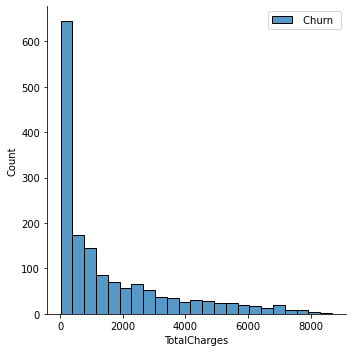

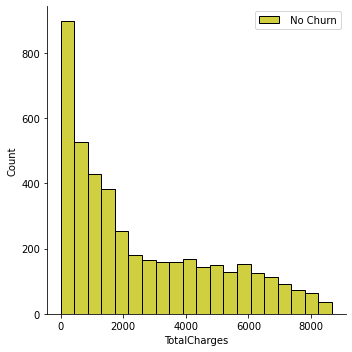

In [137]:
plt.figure("TotalCharges")
sns.displot(data=df_churn,x = 'TotalCharges',label=" Churn ")
plt.legend()
sns.displot(data=df_retained,x = 'TotalCharges',label=" No Churn",color ='y')
plt.legend()
plt.show()


It can be seen in the below plots,people with parters are more likely to stay with the network.we can future analyse
how parters influence montly charges and tenure.

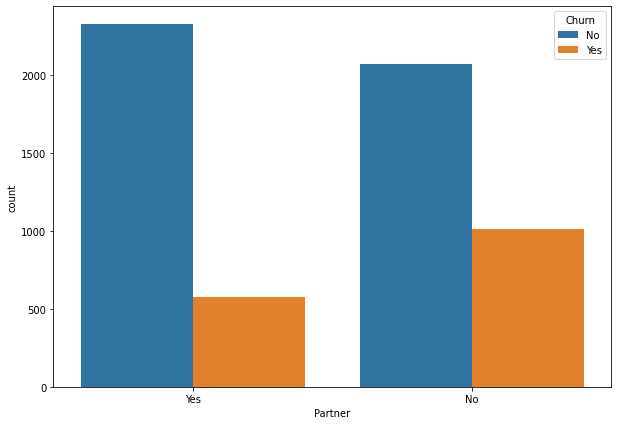

In [138]:
plt.figure(figsize = (10,7))
sns.countplot(x=data.Partner, hue = data.Churn)
plt.show()

As expected, having partner not only makes customer more likely to stay but also likely to pay more for the network.

<ipython-input-139-1118f9cda4f8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('Partner')['TotalCharges', 'MonthlyCharges', 'tenure'].mean().plot(kind = 'bar', stacked = True,


<AxesSubplot:xlabel='Partner'>

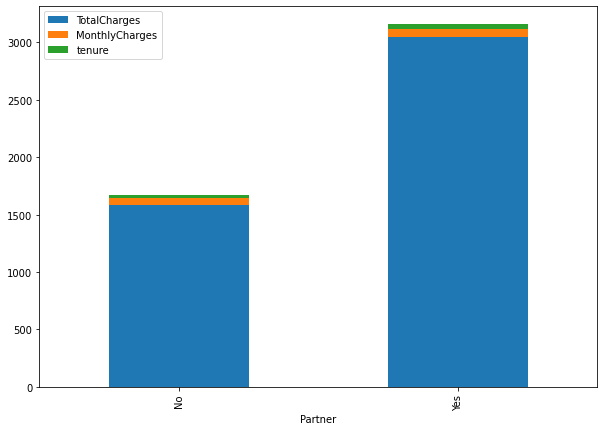

In [139]:
data.groupby('Partner')['TotalCharges', 'MonthlyCharges', 'tenure'].mean().plot(kind = 'bar', stacked = True, 
                                                                             figsize = (10,7))

Below plots reveals, its is more likely for customers to have dependents if they partners,
we could furture analyse how dependents are influencing customers tenure and montly charges 

<AxesSubplot:xlabel='Partner'>

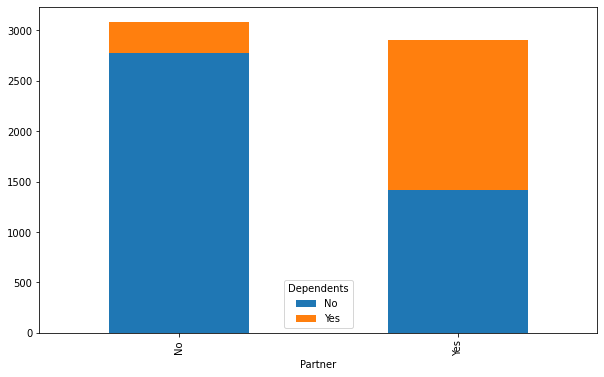

In [140]:
pd.crosstab(data.Partner, data.Dependents).plot(kind = 'bar', stacked = True, figsize = (10,6))

Looking into how gender and senior citizen influencing the churining, it can be observed in the below charts.
gender does not seem to be having any role while senior citizens are more likely to leave the service.
we can future try analyse the factors influencing the seniors to leave the serive.

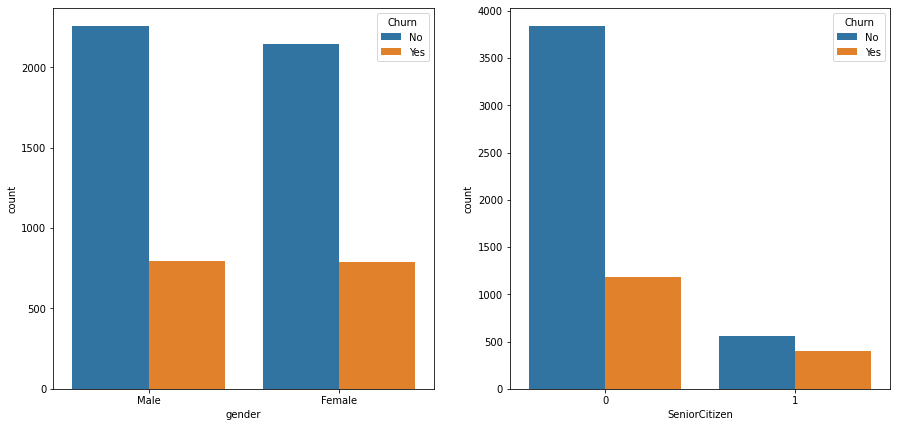

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7))
sns.countplot(x=data.gender, hue = data.Churn,ax=ax1)
sns.countplot(x=data.SeniorCitizen, hue = data.Churn,ax=ax2)
plt.show()

Text(0.5, 1.0, 'Total Revenue by Seniors and Non-Seniors')

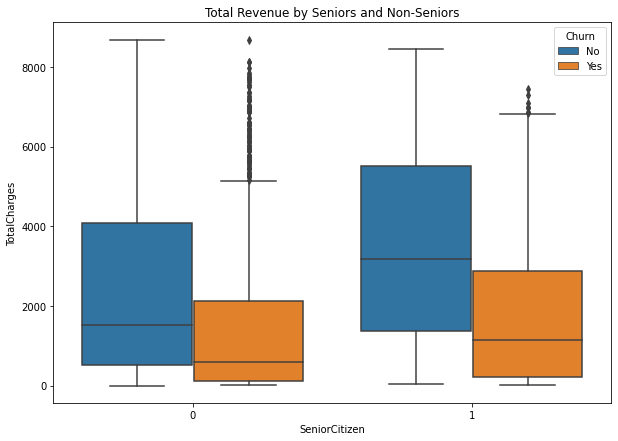

In [142]:
plt.figure(figsize = (10,7))
sns.boxplot(x = data.SeniorCitizen, y = data.TotalCharges, hue = data.Churn)

plt.title('Total Revenue by Seniors and Non-Seniors')

In [143]:
services =['PhoneService','MultipleLines',
                      'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                      'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

In [144]:
def plotServices(feature):
    plt.figure(figsize=(25,20))
    for i, service in enumerate(list(services)):
        plt.subplot(3,4,i+1)
        sns.countplot(x=service,hue = data[feature],data=data)
        plt.ylim(0,5000)
    plt.show()
 

On plotting churning data against all the possible services,the observations that are more pronounced are :<br>
    <br>1)genearlly, people with no internet connection tend to stay with the network while people with
      optical fibers are more likely to leave<br> 
    2)customers with internet connnection but no online security,online backup, device protection or tech support
      is more likely to churn <br>
    3)Longer the tenure , more likely for customer to stay<br>

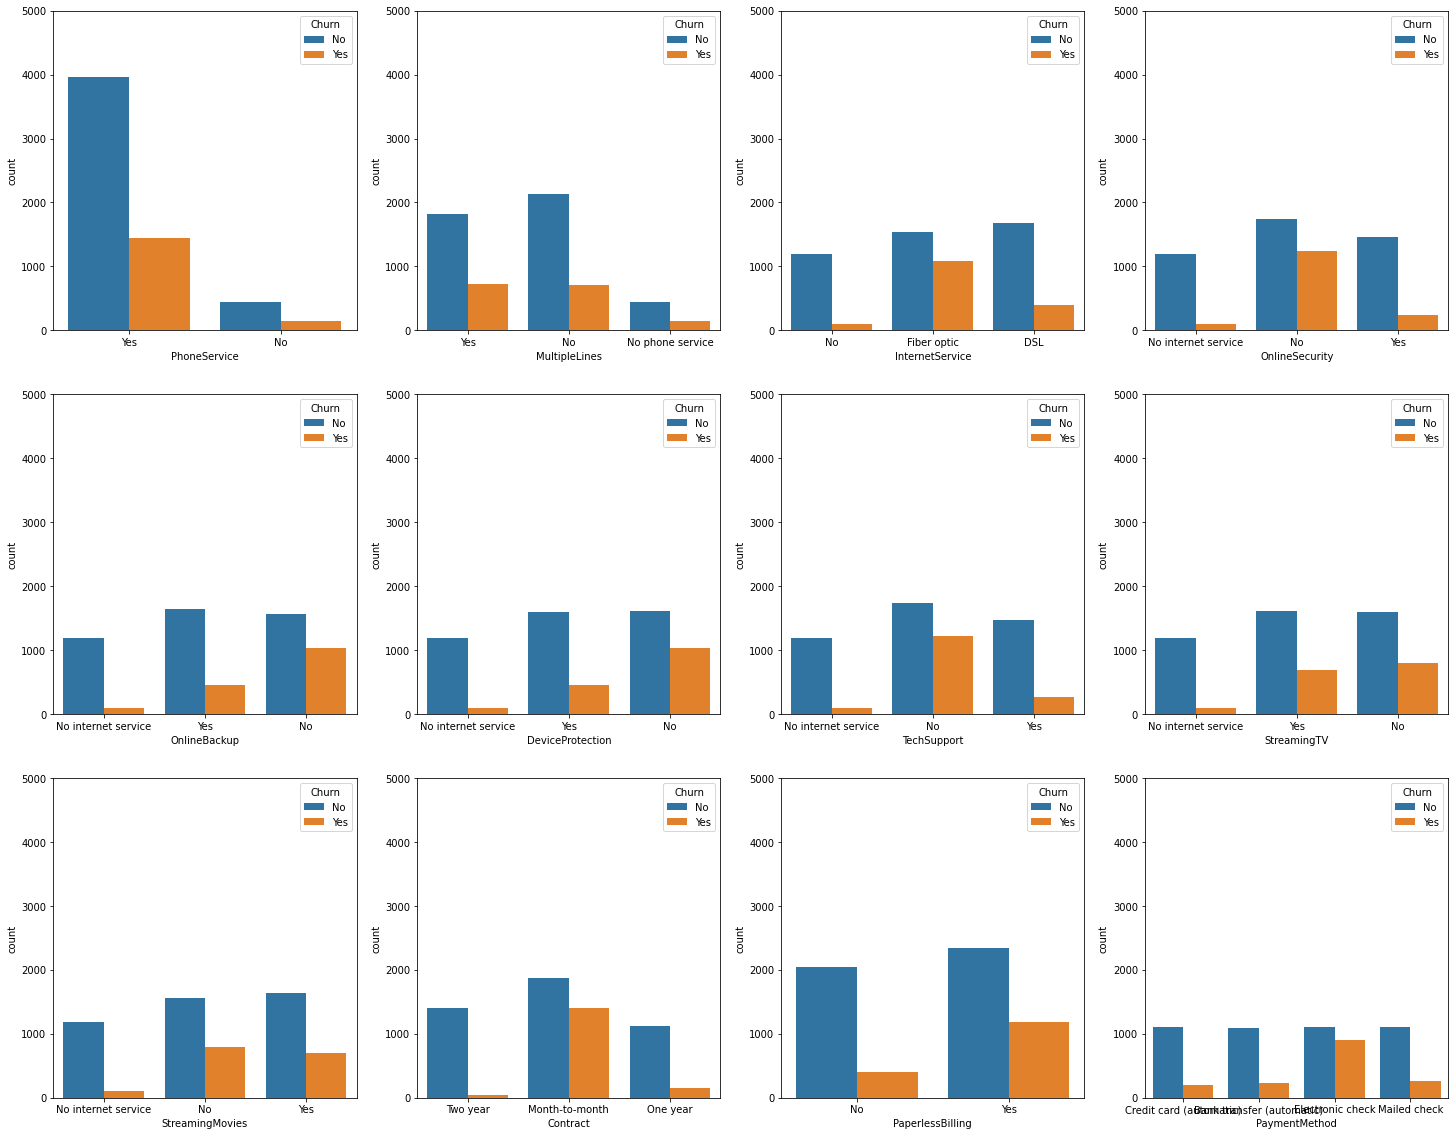

In [145]:
plotServices("Churn")

Below plots gives the distribution of services usage among young and senior people.The observations are :<br>
   <br> 1)counter intuitively, there are only few senior people who do not use internet serives<br> 
    2)senior people more likely to use fiber optics and majority of them are on month-to-month base contract

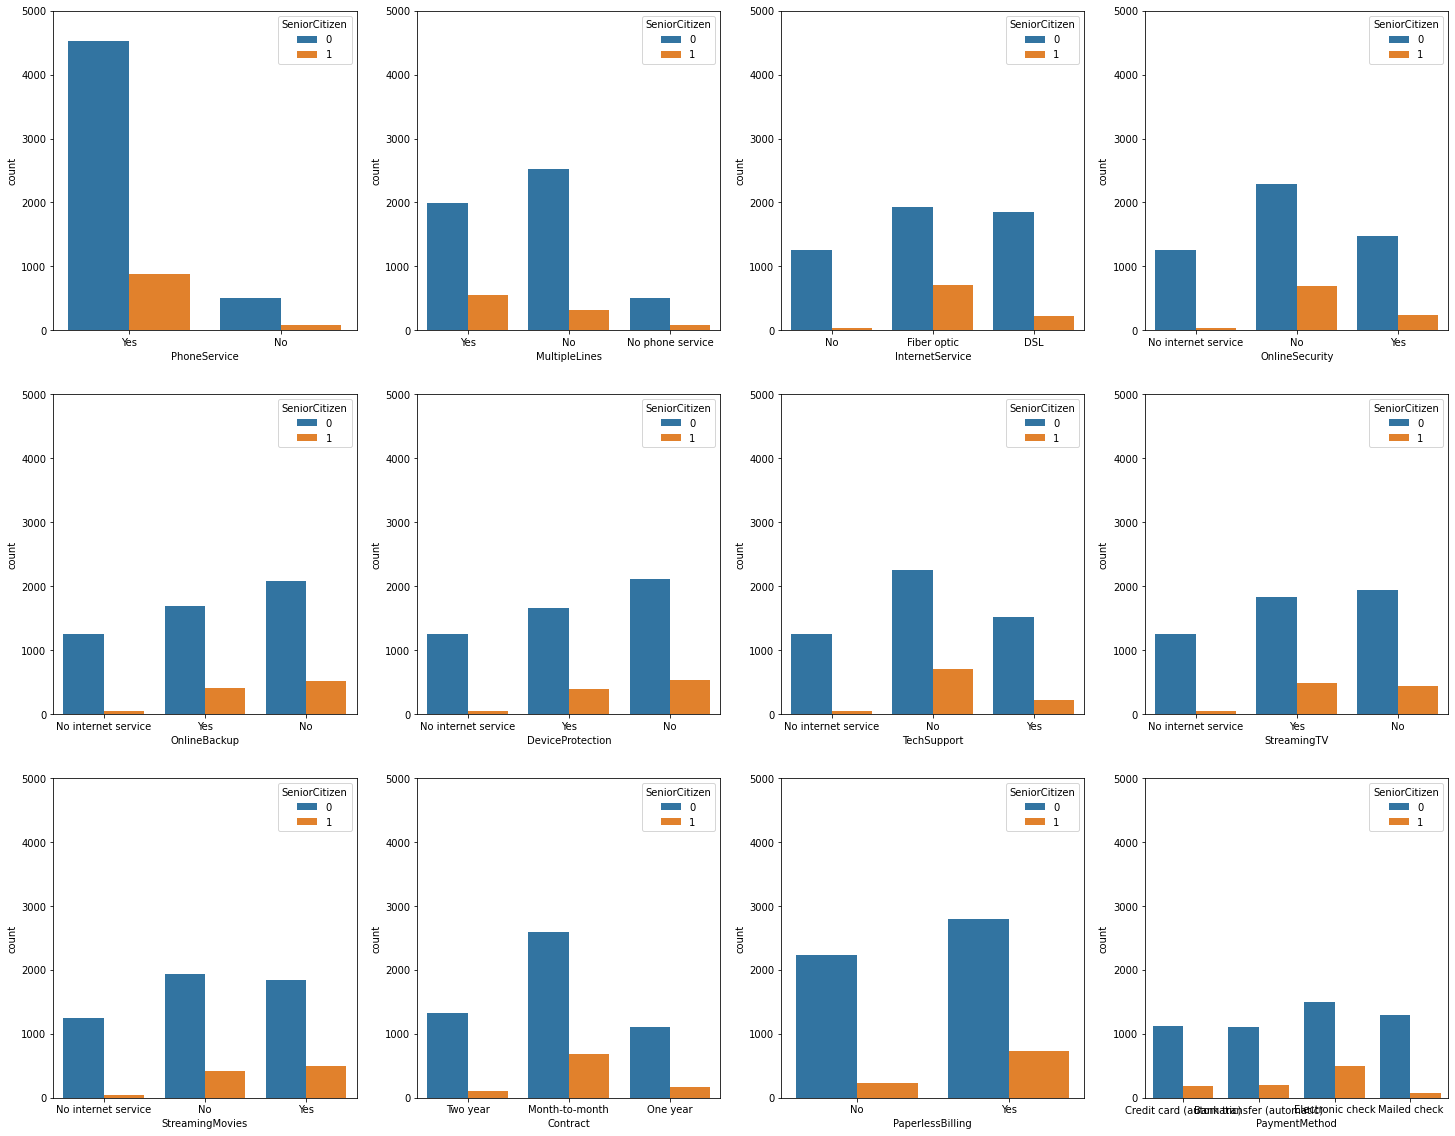

In [146]:
plotServices("SeniorCitizen")

Observations regarding people who live with partner:<br>
    <br> They prefer month-on-month contract 

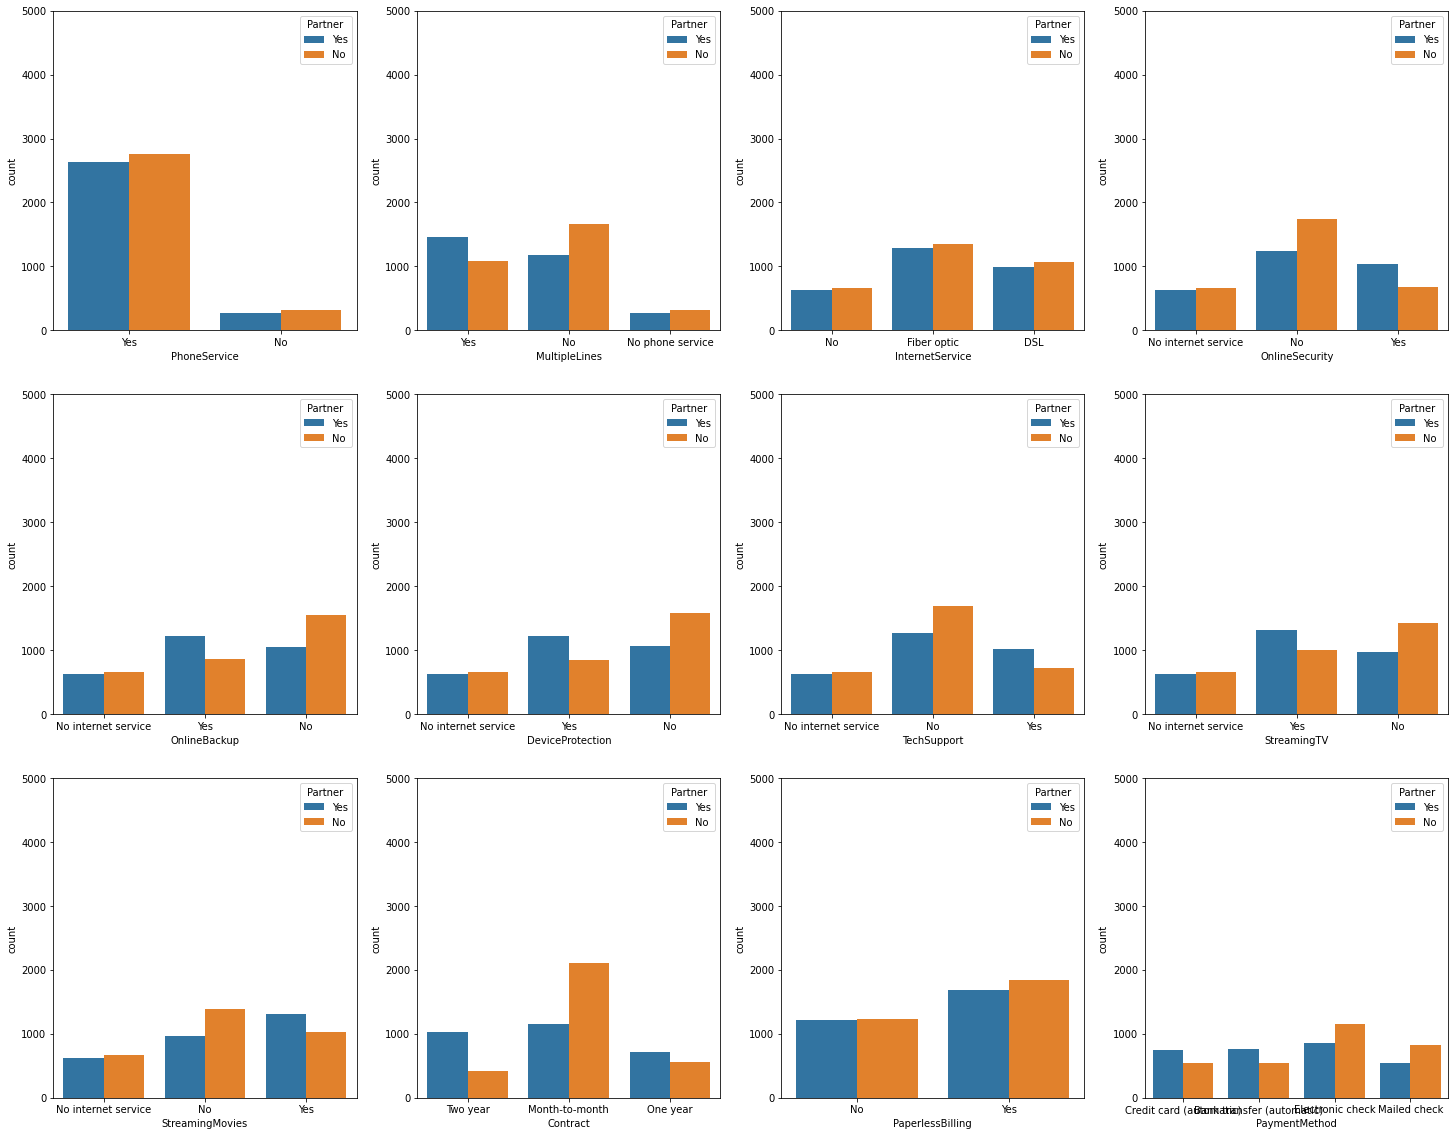

In [147]:
plotServices("Partner")

Customers  with dependents prefer phoneService,Fiber optic ,online security,tech support and they are mostly 
on month-on-month contract

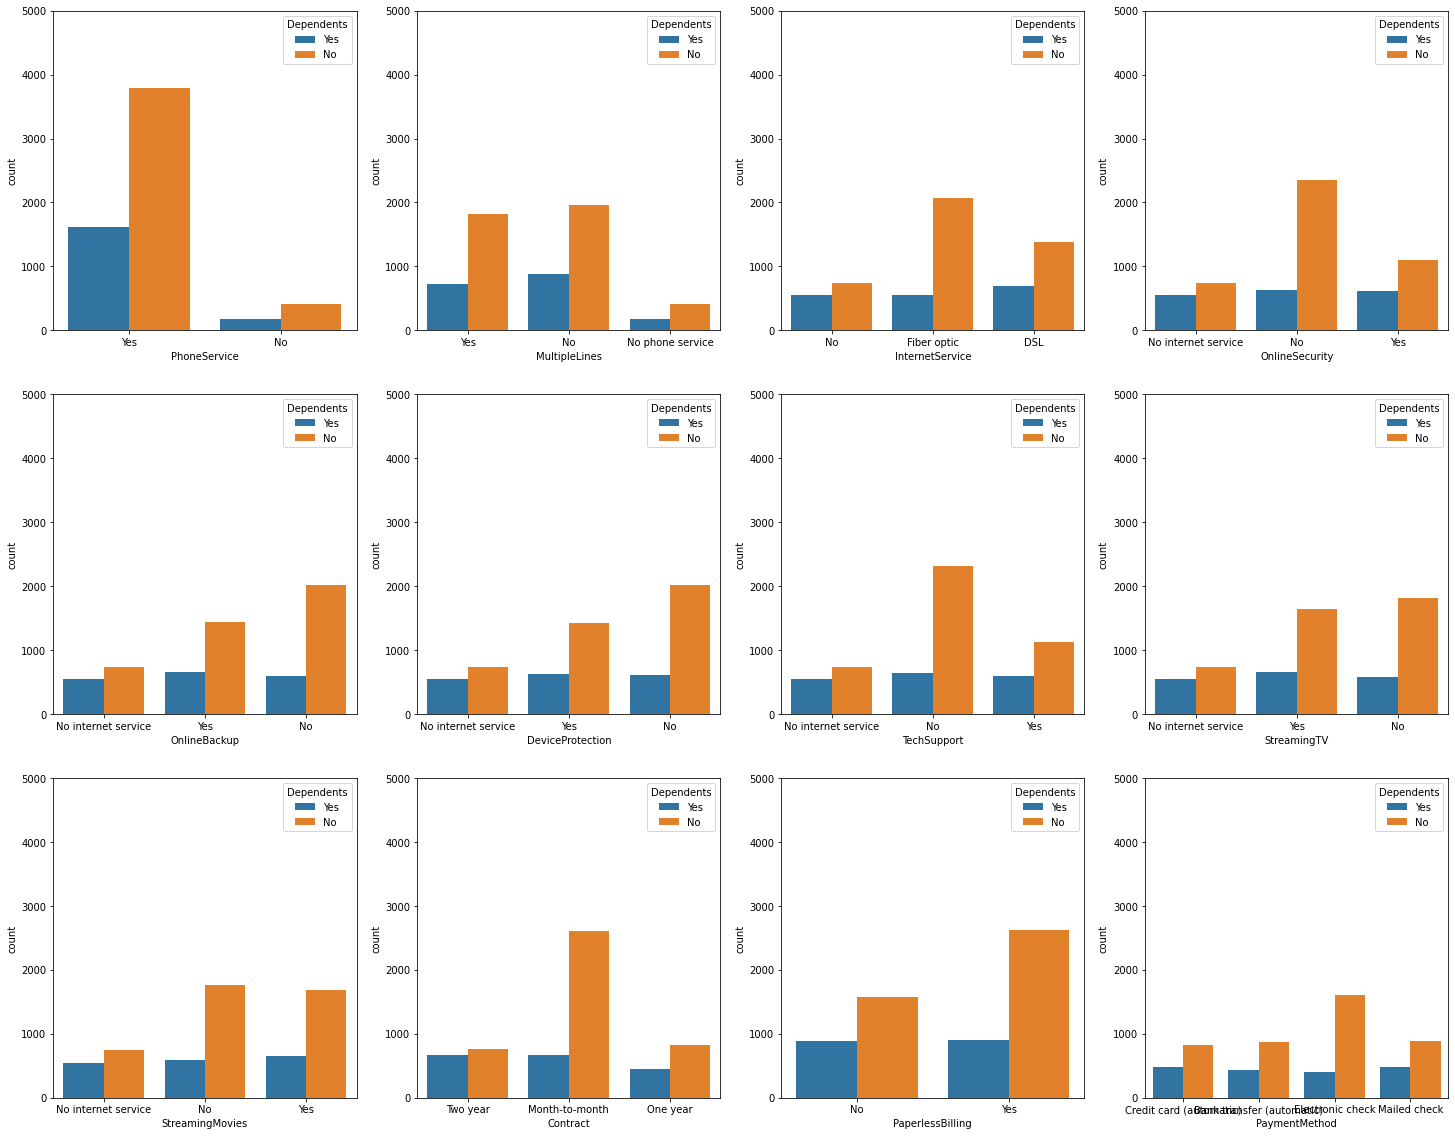

In [148]:
plotServices("Dependents")

In [149]:
data.drop(['customerID'],axis = 1,inplace=True)
data['SeniorCitizen'] = data['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [150]:
categorical_columns =['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines',
                      'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                      'TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod']
numerical_columns =['tenure','MonthlyCharges','TotalCharges']

X = data[categorical_columns+numerical_columns]
y = data['Churn']

## Chi Square Test 

Chi-square is a test of independence between feature and target varibale.<br>
Below plot shows features 'gender' and 'PhoneService' are failing the test at significance level 5%

In [151]:
#performs chi-sqaure test and retures all the p-values of categorical varibales 
def get_chi2_values(data_cat, target, alpha=0.05):
    p_val = dict()
    ind_var = dict()
    for col in data_cat.columns:
        contengency = pd.crosstab(index = data_cat[col],columns=target)
        chi2, p, dof, ex = chi2_contingency(contengency)
        p_val[col] = p
        if p > alpha:
            ind_var[col] = p
    
    print(f'Varibales that failed chi square test at siginificance level {alpha} are:')
    print(ind_var)
    print('\n')
    return p_val
    

Varibales that failed chi square test at siginificance level 0.05 are:
{'gender': 0.4780481366595716, 'PhoneService': 0.49662979409934027}




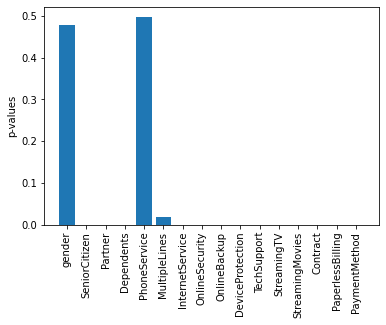

In [152]:
#get the p-values for all categorical varibales 
p_val = get_chi2_values(X[categorical_columns],y)
plt.bar(*zip(*p_val.items()))
plt.xticks(rotation=90)
plt.ylabel("p-values")
plt.show()

## Heat Map

A heat map  shows correlation coefficients between variables.A highly co-linear varibales need to be avoided for better 
performances in many models 

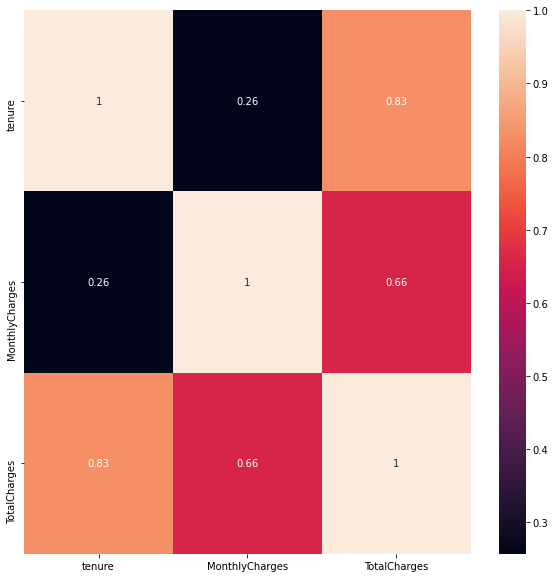

In [153]:
num_cor = X[numerical_columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(num_cor,annot=True)
plt.show()

## one-way Anova

here , Target variable is categorical and few of the features are numerical ,so ,One-way anova
is used to identify the feature signifinace of those neumarical features. 
Below plot shows the f values of all 3 numerical varibales,which have passed significance test at 5%

In [154]:
# configure to select all features
fs = SelectKBest(score_func=f_classif, k='all')
# learn relationship from training data
fs.fit(X[numerical_columns], y)

SelectKBest(k='all')

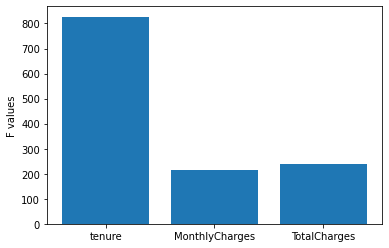

In [155]:
plt.bar(numerical_columns, fs.scores_)
plt.ylabel("F values")
plt.show()


In [156]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size = 0.3 ,random_state=42)

In [157]:
X_train.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,tenure,MonthlyCharges,TotalCharges
5369,Female,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,34,20.35,673.20
1329,Female,No,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),72,19.40,1496.45
3457,Female,No,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1,19.50,19.50
765,Female,No,No,No,No,No phone service,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,11,35.80,363.15
6776,Female,Yes,Yes,No,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),62,79.95,4819.75


## permutation importance

It is the mechanishm to compute the feature importance, it Shuffles the values in a single column, 
make predictions using the resulting dataset. Use these predictions and the true target values to
calculate how much the loss function suffered from shuffling.
That performance deterioration measures the importance of the variable you just shuffled.
As it can been seen in the below box plot, 'contract' ,'tenure', 'online security', 'internet service' 
are the most important features while 'streaming movies' and 'seniorCitizen' are the least importance 

In [158]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'SeniorCitizen',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                          

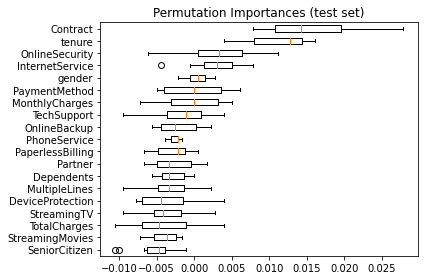

In [159]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Based on the observations made on feature selections techinques,<br>
we can say **'Contract','tenure','OnlineSecurity','InternetService','PaymentMethod'** are the important featurtes 
now we can campare model performance on both overall features and reduced features to see if the performance is really 
improved 

In [160]:
data['Churn'].replace(to_replace='Yes', value=1, inplace=True)
data['Churn'].replace(to_replace='No',  value=0, inplace=True)

data['SeniorCitizen'] = data['SeniorCitizen'].apply(lambda x: 'Yes' if x == 1 else 'No')

#data set for reduced model
data_reduced = data[['Contract','tenure','OnlineSecurity','InternetService','PaymentMethod','Churn']]
data_reduced_enc = pd.get_dummies(data_reduced,columns=['Contract','OnlineSecurity','InternetService','PaymentMethod'],
                        drop_first=True)

#data set for overall model
data_enc=pd.get_dummies(data,columns=['gender','SeniorCitizen','Partner','Dependents','PhoneService',
                                      'MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                                     'TechSupport','StreamingTV','StreamingMovies',
                                      'Contract','PaperlessBilling','PaymentMethod'],drop_first=True)

## Data Partition  

Data splitting for both reduced and overall model in 70:30 fasion

In [161]:
# data splitting for overall model
data_X = data_enc.drop(['Churn'],axis =1)
data_y = data_enc['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_y,test_size = 0.3)

#data spliting for reduced model
data_X_reduced = data_reduced_enc.drop(['Churn'],axis =1)
data_y_reduced = data_reduced_enc['Churn']
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    data_X_reduced, data_y_reduced,test_size = 0.3)

Since data is unbalnaced,oversampling uisng smote is performed. Here, resampling is done only on training data ,not on 
validation and test data. kfold cross validation is used with grid search to get best parameters.<br>
A glance at class distribution reveals data is unbalanced, that makes classification accuracy not a 
right metric to measure performance.
Since companies aim to retain the customers as much as possible, identification of churning is of a
paramount importance and here type 1 error (wrongly marking customer as potential churn) is less detrimental 
compared to type 2 error (Failed to identify the churn).So recall alongside F1 score is the right metric.  




In [162]:
kf = KFold(n_splits=5, shuffle=False)
def fitModel(model,params,X_train,y_train,model_name):
    pipeline = make_pipeline(SMOTE(random_state=42),model)
    new_params = {model_name + key: params[key] for key in params}
    best_mod = GridSearchCV(pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
    best_mod.fit(X_train, y_train)
    return best_mod


    

In [163]:
#displays the recall score and f1 score for a model passed 
def displayPerfScore(model_overall,model_reduced,model_name,X_test,X_test_red):
    y_test_predict = model_overall.predict(X_test)
    y_test_pred_reduced = model_reduced.predict(X_test_red)
    print('\033[1m' + model_name+':            '  +  'Full model '+ '         Reduced model'+'\033[0m')
    print('recall_score          '+ str(recall_score(y_test, y_test_predict))+ '    '+
          str(recall_score(y_test, y_test_pred_reduced)))
    print('f_score                '+str(f1_score(y_test, y_test_predict,average='weighted'))+ '    '
          +str(f1_score(y_test, y_test_pred_reduced,average='weighted')))

## Random forest

In [164]:
params_rf = {'n_estimators':[100],'max_depth': [5], 
          'min_samples_split':[2, 5],
                'min_samples_leaf': [1] }
best_model_overall = fitModel(RandomForestClassifier(random_state=42),params_rf,X_train,
                              y_train,'randomforestclassifier__')
best_model_reduced = fitModel(RandomForestClassifier(random_state=42),params_rf,X_train_red,
                              y_train_red,'randomforestclassifier__')

print('CV score of random forest is: ' + str(best_model_overall.best_score_))
best_model_reduced.best_params_

CV score of random forest is: 0.7509071208190028


{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 5,
 'randomforestclassifier__n_estimators': 100}

## Gradient Boosting

In [165]:
params_gb = {'n_estimators': [100,50],'max_depth': [2],
                'min_samples_leaf': [1],'learning_rate':[0.03],'min_samples_split': [3]}
best_model_overall = fitModel(GradientBoostingClassifier(random_state=42),params_gb,X_train,
                              y_train,'gradientboostingclassifier__')
best_model_reduced = fitModel(GradientBoostingClassifier(random_state=42),params_gb,X_train_red,
                              y_train_red,'gradientboostingclassifier__')
print('CV score of Gradient boosting  is: ' + str(best_model_overall.best_score_))
best_model_reduced.best_params_

CV score of Gradient boosting  is: 0.7983574071639903


{'gradientboostingclassifier__learning_rate': 0.03,
 'gradientboostingclassifier__max_depth': 2,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__min_samples_split': 3,
 'gradientboostingclassifier__n_estimators': 50}

###  Test data Prediction

Gardinet boosting the model which has the highest cross validation score.Lets predict the the test set using that model.<br>
As can been seen in the below table, full model is performing well. Need to future investigate on why assumptions made based 
on feature importance techinques are not satisfied.


In [166]:
displayPerfScore(best_model_overall,best_model_reduced,'Gradient boosting',X_test,X_test_red)
#best_model_reduced.best_params_

Gradient boosting:            Full model          Reduced model
recall_score          0.8340425531914893    0.46808510638297873
f_score                0.7205971759781862    0.5730796390707374
